Protein conformational transitions are fundamental to functions of many proteins. Computational methods are valuable for elucidating such transitions in atomistic details. I used computational simulations to model the transition path between different protein conformational states through cycles of path optimizations. 
The simulation method is under development, therefore post-simulation data processing was largely missing. I wrote the Python codes to analyze the simulation results. Some examples are shown here.
I first define two functions to convert the data format of the output files.

In [1]:
# functions to convert file shape for processing, and get slice index

def convert(filename):
    """extract the slice index from each block"""
    with open(filename, 'r') as content_file:
        content = content_file.read()
        data = [float(i) for i in content.split()[cv::(cv+1)]]
    return data

def convert_shape(filename):
    """convert the file to np array of shape slice by cv"""
    datalist = []
    data = np.zeros((slice,cv))
    with open(filename, 'r') as f:
        for line in f:
            temp = line.split()
            for i in temp:
                datalist.append(float(i))
    data = np.array(datalist).reshape(slice,cv)
    return data

For the analysis, the first step is to check convergence of the simulation. The convergence can be visualized by a plateu of the A_RMSD value I defined. 

parser1 Done! (0.022 seconds)


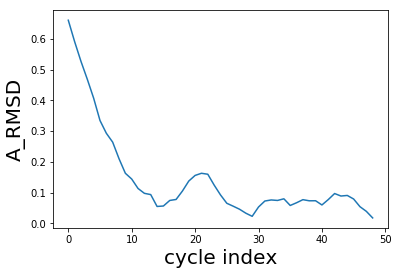

In [3]:
#from convert import convert_shape


def parser1(startIdx, endIdx, ofile):
    global indl, slice, cv
    odata = np.zeros(endIdx-startIdx)
    data1 = np.zeros((slice,cv))
    data2 = np.zeros((slice,cv))
    data3 = np.zeros((slice,cv))
    file1 = "cyc"+str(endIdx).zfill(indl)+"/smean.dat"
    data1[:] = convert_shape(file1)
    for i in range(startIdx, endIdx):
        file2 = "cyc"+str(i).zfill(indl)+"/smean.dat"
        data2 = convert_shape(file2)   
        data3 = data1-data2
        data3[:,0] = np.linalg.norm(data3[:], axis=1)      # Compute sqrt(sum((x2-x1)^2))
        odata[i-1] = np.sum(data3[:,0])/slice      # Compute sqrt(sum((y2-y1)^2))
    np.savetxt(ofile,odata)

if __name__ == '__main__':
    from os import listdir
    import numpy as np
    from time import time
    import matplotlib.pyplot as plt

    indl = 3  # cycle index digits
    slice = 200  
    cv = 2    
    start_time = time()
    """Step 1: find start index and end index of cyc*** files"""
    ifiles = [f for f in listdir('.') if f.startswith('cyc')]
    idx = np.zeros(len(ifiles), dtype=np.int)
    for i in range(len(ifiles)):
        idx[i] = int(ifiles[i][indl:])

    """Step 2: parse the cyc*** data files""" 
    parser1(idx.min(),idx.max(),"result.dat")         
    print ("parser1 Done! (%5.3f seconds)" % (time()-start_time))
    
    """Step 3: plot "A_RMSD" """ 
    data = np.loadtxt('result.dat')
    plt.show()
    plt.plot(data)
    plt.xlabel('cycle index', fontsize=20)
    plt.ylabel('A_RMSD', fontsize=20)
    plt.savefig('rmsd.eps', transparent=True)
#    plt.show()


In the optimization, the structural difference between the different states was represented by collective variables to largely reduce the number of dimensions. Here we look at the eolvement of the collective variables and further validate the convergence of the simulation. A simple example of two collective variables is shown.

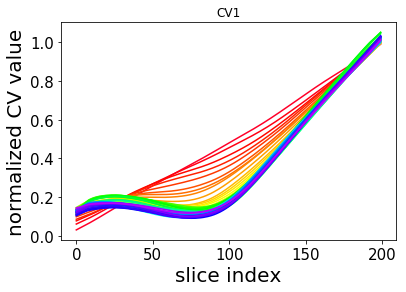

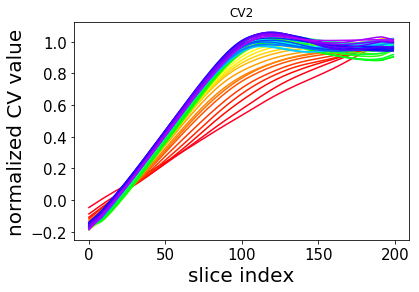

In [4]:
#plot CV values for each cycle in a plot, for all CVs
#from convert import convert_shape


def parser2(theIdx):
    """compute normalized cv for the current cycle"""
    data1 = np.zeros((slice,cv))
    file1 = "cyc"+str(theIdx).zfill(3)+"/smean.dat"
    data1[:] = convert_shape(file1)
    cvfile = np.loadtxt('init.dat')
    for i in range(slice):
        data1[i,:] = (data1[i,:]-cvfile[0,:])/(cvfile[1,:]-cvfile[0,:])
    return data1

if __name__ == '__main__':
    from os import listdir
    import numpy as np
    import matplotlib.pyplot as plt
    slice = 200
    cv = 2
    cycle = 50


    """parse the cyc*** data files and plot the CV path"""
    for j in range(cv):
        plt.figure()
        colormap = plt.cm.gist_rainbow
        plt.gca().set_prop_cycle('color', [colormap(k) for k in np.linspace(0,0.9,cycle)])
        plt.title('CV'+str(j+1))
        plt.xlabel('slice index',fontsize=20)
        plt.ylabel('normalized CV value',fontsize=20)
        plt.tick_params(axis='both', which='major', labelsize=15)
        plt.tick_params(axis='both', which='minor', labelsize=15)
        for i in range(cycle):
            formdata = parser2(i+1)       # Change output file name here! 
            plt.plot(formdata[:,j])
        plt.savefig('cv'+str(j+1)+'.eps', transparent=True)
    plt.show()
    

The interpretation of the structures during the transition has been lacking in previous results. Here we extract structures along the transition path to build a transition trajectory for further analysis.
(Note: a visualization is not provided here for other tools are required.)

In [ ]:
# extract a structure for each slice and get a combined trajectory

import numpy as np
import MDAnalysis as mda
import os
from time import time
from MDAnalysis.analysis.align import *
#from convert import convert


if __name__ == '__main__':
    rep = 4
    block = 7
    slicenum = 200
    frame = 30
    cv = 7
    start_time = time()

    """save a structure for each slice index and combine all frames and output the combined trajectory"""
    for i in range(rep):
        for j in range(block):
            psffile = '3ert.psf'
            trajfile = 'rep'+str(i).zfill(3)+'/block'+str(j+1).zfill(3)+'.dcd'
            cvfile = 'rep'+str(i).zfill(3)+'/block'+str(j+1).zfill(3)+'.cv'
            slice_idx = convert(cvfile)
            u = mda.Universe(psffile,trajfile)
            protein = u.select_atoms('protein')
            m = 0
        for ts in u.trajectory:
            tempname = 'slice'+str(slice_idx[m]).zfill(4)+'_temp.dcd'
            if not os.path.isfile(tempname):
                with mda.Writer(tempname, protein.n_atoms) as w:
                    w.write(protein)
            m += 1
    psffile = '3ert.psf'
    ref = mda.Universe('1qku_namd.pdb')
    with mda.Writer('path_full.dcd', n_atoms=3987) as w2:
        for k in range(slicenum):
            trajfile = 'slice'+str(k+1).zfill(4)+'_temp.dcd'
        if os.path.isfile(trajfile):
            u2 = mda.Universe(psffile,trajfile)
            rms_fit_trj(u2, ref, filename='temp.dcd') #align the frame with the reference
            u3 = mda.Universe(psffile,'temp.dcd')
            for ts in u3.trajectory:
                w2.write(u3.select_atoms('protein'))
                os.remove('temp.dcd')
    
    print ("Done!(%5.3f seconds)" % (time()-start_time))
